In [449]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# import plotly.express as px

# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке.
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

In [450]:
df = pd.read_csv('amazon_co-ecommerce_sample.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

In [451]:
df.columns

Index(['manufacturer', 'price', 'number_available_in_stock',
       'number_of_reviews', 'number_of_answered_questions',
       'average_review_rating', 'amazon_category_and_sub_category'],
      dtype='object')

In [452]:
df["number_available_in_stock"] # странно...

0        5 new
1          NaN
2        2 new
3          NaN
4          NaN
         ...  
9995     5 new
9996       NaN
9997     3 new
9998     3 new
9999    31 new
Name: number_available_in_stock, Length: 10000, dtype: object

In [453]:
df.head

<bound method NDFrame.head of                  manufacturer   price number_available_in_stock  \
0                      Hornby   £3.42                     5 new   
1                   FunkyBuys  £16.99                       NaN   
2                         ccf   £9.99                     2 new   
3                      Hornby  £39.99                       NaN   
4                      Hornby  £32.19                       NaN   
...                       ...     ...                       ...   
9995                   Mattel  £22.95                     5 new   
9996                Star Wars  £39.99                       NaN   
9997  Olde Scotland Yard Ltd.  £43.99                     3 new   
9998                DC Comics  £49.81                     3 new   
9999                   Bandai  £21.20                    31 new   

     number_of_reviews  number_of_answered_questions average_review_rating  \
0                   15                           1.0    4.9 out of 5 stars   
1        

## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

Выведем тепловую карту для визуализации пропущенных значений. Желтый - значение пропущено, синий - нет.

<Axes: >

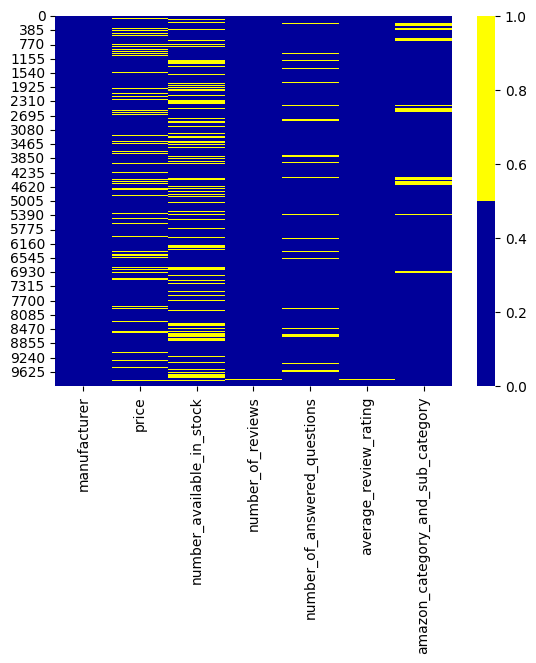

In [454]:
cols = df.columns
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Посмотрим на процентные соотношения пропущенных данных и непропущенных

In [455]:
df.isnull().sum()

manufacturer                           7
price                               1435
number_available_in_stock           2500
number_of_reviews                     18
number_of_answered_questions         765
average_review_rating                 18
amazon_category_and_sub_category     690
dtype: int64

In [456]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

manufacturer - 0%
price - 14%
number_available_in_stock - 25%
number_of_reviews - 0%
number_of_answered_questions - 8%
average_review_rating - 0%
amazon_category_and_sub_category - 7%


в столбце number_available_in_stock содержится 2500 пропущенных значений, что добавляет смысла к удалению этого столбца

In [457]:
df = df.drop(columns=['number_available_in_stock'])

## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.

In [458]:
from sklearn.preprocessing import OrdinalEncoder

Уберем лишние знаки из значения цены, если цена не указана приравняем её равной медиане цены. Медиану будем считать без значений цены равных NaN

In [459]:
def mapprice(v):
    if isinstance(v, str) and '£' in v:
        v = float(v.split('£')[1])
        return v

7094 значение поломанное из-за цены в виде 2,439.92. Легче выкинуть

In [460]:
df_for_price = df
df_for_price = df_for_price.drop(7094)
df_for_price = df_for_price.dropna(subset=['price'])
df_for_price['price'] = df_for_price[~df_for_price['price'].str.contains('-')]['price']

df = df.drop(7094)
price_median = df_for_price['price'].apply(mapprice).median()
df['price'] = df['price'].fillna(price_median).astype(str)
df['price'] = df[~df['price'].str.contains('-')]['price'].apply(mapprice).apply(lambda x: float(x))
df = df.dropna(subset="price")

Закодируем с помощью OrdinalEncoding столбцы manufacturer и amazon_category_and_sub_category

In [461]:
df = df.dropna(subset = 'manufacturer', axis = 0) 
df = df.dropna(subset = 'amazon_category_and_sub_category', axis = 0) 

In [462]:
encoder = OrdinalEncoder()
df['manufacturer'] = encoder.fit_transform(df[['manufacturer']])
df['amazon_category_and_sub_category'] = encoder.fit_transform(df[['amazon_category_and_sub_category']])

Обработаем столбцы number_of_answered_questions, number_of_reviews и average_review_rating

In [463]:
def get_rating_num(s):
    if isinstance(s, str):
        return float(s.split()[0])
    return s

In [464]:
def get_reviews_num(v):
    if isinstance(v, str):
        v = v.replace(',', '.')
        v = float(v)
        return v

так как медиана рейтинга будет равна 5 мы используем среднее значение, а не медиану для неё

In [465]:
median_number_of_answered_questions = df['number_of_answered_questions'].median()
median_number_of_reviews = df['number_of_reviews'].apply(get_reviews_num).median()
mean_average_review_rating = df.dropna(subset='average_review_rating')['average_review_rating'].apply(get_rating_num).mean()
df['number_of_answered_questions'] = df['number_of_answered_questions'].fillna(median_number_of_answered_questions)
print(mean_average_review_rating)
df['average_review_rating'] = df['average_review_rating'].fillna(mean_average_review_rating)
df['average_review_rating'] = df['average_review_rating'].apply(get_rating_num)

4.709194538394088


In [466]:
df['number_of_reviews'] = df['number_of_reviews'].fillna(median_number_of_reviews)
df['number_of_reviews'] =  df['number_of_reviews'].apply(get_reviews_num)
df['number_of_reviews'] = df['number_of_reviews'].fillna(median_number_of_reviews)

In [467]:
df.shape

(7993, 6)

In [468]:
df.isnull().sum()

manufacturer                        0
price                               0
number_of_reviews                   0
number_of_answered_questions        0
average_review_rating               0
amazon_category_and_sub_category    0
dtype: int64

In [469]:
df.dtypes

manufacturer                        float64
price                               float64
number_of_reviews                   float64
number_of_answered_questions        float64
average_review_rating               float64
amazon_category_and_sub_category    float64
dtype: object

# Обучение модели (3 балла)

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

In [470]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [471]:
X = df.drop(["price"],axis=1)
y = df["price"]

In [472]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [473]:
d_regr = DummyRegressor()
d_regr.fit(X_train, y_train)
d_regr_pred = d_regr.predict(X_test)
d_regr_pred

array([19.67142484, 19.67142484, 19.67142484, ..., 19.67142484,
       19.67142484, 19.67142484])

In [474]:
d_regr.score(X_test, y_test)

-0.0001696570328513225

In [475]:
MSE = mean_squared_error(y_test, d_regr_pred)
RMSE = np.sqrt(MSE)
MSE, RMSE

(1602.4082871005483, 40.030092269448346)

## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.

In [476]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [477]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr_pred = dtr.predict(X_test)

In [478]:
r2 = r2_score(y_test, dtr_pred)

Ниже можно увидеть, что результат ухудшился

In [479]:
MSE = mean_squared_error(y_test, dtr_pred)
RMSE = np.sqrt(MSE)
MSE, RMSE, r2

(2139.23177044281, 46.25182991453214, -0.33523692019155726)

## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

In [480]:
from sklearn.linear_model import LinearRegression

In [481]:
linRegr = LinearRegression()
linRegr.fit(X_train,y_train)
linRegr.score(X_train,y_train)

0.0038687629004738877

In [482]:
linRegr_pred = linRegr.predict(X_test)
r2_score(y_test, linRegr_pred)

0.0030542874952468324

r2_score стал значительно ниже результата в дереве решений

# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

In [483]:
def plot_fitting_curve(parameter: str, values: list, score, X_train, X_test, y_train, y_test):
    train_curve = []
    test_curve = []
    for value in values:
        # инициализация объекта из словаря
        # распаковка словаря через ** эквивалентна перечислению аргументов
        model = DecisionTreeRegressor(**{parameter: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(score(y_train, y_pred_train))
        test_curve.append(score(y_test, y_pred_test))
    sns.lineplot(x=values, y=train_curve, color = 'red')
    sns.lineplot(x=values, y=test_curve)

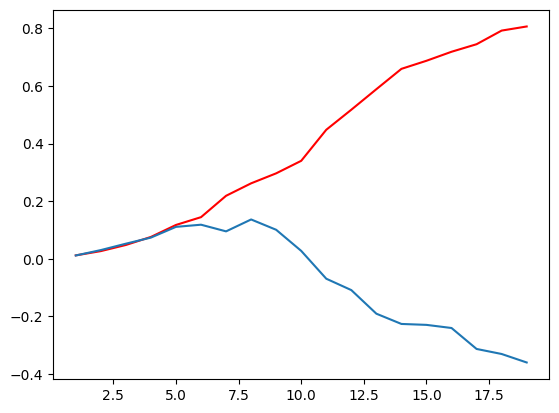

In [484]:
plot_fitting_curve('max_depth', np.arange(1, 20), r2_score, X_train, X_test, y_train, y_test)

# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [523]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self.num_trees= num_trees
        self._samples_frac = 0.8
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]
    def fit(self, x, y: pd.Series):
        x = pd.DataFrame(x)
        y = y.reset_index(drop=True)
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=42)
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)
        return self

    def predict(self, x: pd.DataFrame):
        x = pd.DataFrame(x)
        res = []
        for i in range(self.num_trees):
          res.append(self._trees[i].predict(x))
        return sum(res) / len(res)

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.